In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# 1. Introduction

In today's digital age, the rapid spread of misinformation and fake news poses a significant threat to society. False information can influence public opinion, disrupt democratic processes, and cause widespread confusion. 

In this project, I aim to develop a deep learning model that classifies news articles as either fake or real using natural language processing (NLP) techniques. Specifically, I will leverage sequential models such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), which are well-suited for processing and understanding the structure and context of human language. These models will be trained on a publicly available dataset of labeled news articles, allowing the model to learn linguistic patterns and cues that often differentiate legitimate journalism from fabricated stories.

By exploring and comparing the performance of LSTM and GRU-based models on this task, the project aims to contribute to the development of robust and scalable tools for misinformation detection. Such tools are essential in the ongoing effort to build safer and more trustworthy digital information ecosystems.

# 2. Import Modules

In [4]:
# these are some modules that I found to set up the training required
import numpy as np
import pandas as pd
import re
import warnings
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D,GlobalMaxPooling1D, GRU, Dense, Flatten, LSTM, Dense, SimpleRNN, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#EDA
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

warnings.filterwarnings('ignore')

2025-06-03 19:35:20.815319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748979321.026640      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748979321.088626      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# random seed for reproducibility
np.random.seed(19)
tf.random.set_seed(19)

# 3. Load Data

In [8]:
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

# 4. Exploratory Data Analysis (EDA)

In [9]:
print("Fake news set shape:", fake.shape)
print("True news set shape:", real.shape)
print("\nFake set columns:", fake.columns.tolist())
print("True set columns:", real.columns.tolist())

Fake news set shape: (23481, 4)
True news set shape: (21417, 4)

Fake set columns: ['title', 'text', 'subject', 'date']
True set columns: ['title', 'text', 'subject', 'date']


In [10]:
# fake news label = 0, true news label = 1

fake['label'] = 0
real['label'] = 1

# combine both fake news and real news, combine title and text
news = pd.concat([fake,real],ignore_index=True)
news['title+text'] = news['title'].astype(str) + ' ' + news['text'].astype(str)

By checking average length of articles by class, the observation shows fake news articles are typically longer 

      text_length                                                          \
            count         mean          std   min     25%     50%     75%   
label                                                                       
0         23481.0  2642.594268  2533.721790  31.0  1530.0  2259.0  3126.0   
1         21417.0  2448.946398  1684.414608  32.0   980.0  2286.0  3301.0   

                
           max  
label           
0      51893.0  
1      29849.0  


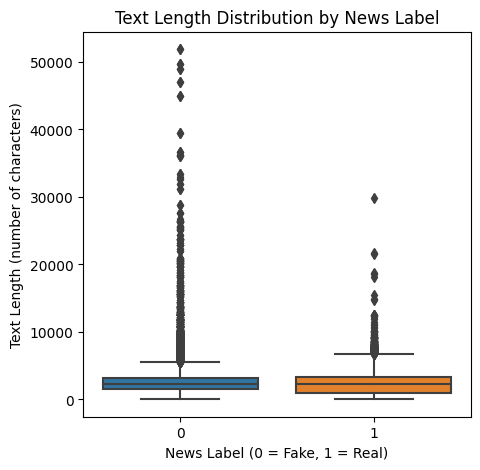

In [11]:
news['text_length'] = news['title+text'].apply(len)
print(news[['text_length', 'label']].groupby('label').describe())

plt.figure(figsize=(5,5))
sns.boxplot(x='label', y='text_length', data=news)
plt.title('Text Length Distribution by News Label')
plt.xlabel('News Label (0 = Fake, 1 = Real)')
plt.ylabel('Text Length (number of characters)')
plt.show()

In [12]:
# list out the 20 most common appearing words in fake news and real news

stop_words = set(stopwords.words('english'))

def get_most_common_words(texts, n=20):
    all_words = ' '.join(texts).lower().split()
    filtered_words = [word for word in all_words if word not in stop_words]
    return Counter(filtered_words).most_common(n)

print("Top words in Fake News:", get_most_common_words(news[news['label'] == 0]['title+text']))
print('\n')
print("Top words in Real News:", get_most_common_words(news[news['label'] == 1]['title+text']))

Top words in Fake News: [('trump', 72126), ('would', 23505), ('president', 23051), ('people', 22775), ('one', 22102), ('said', 21406), ('obama', 17688), ('donald', 17618), ('like', 17224), ('clinton', 16496), ('new', 14818), ('also', 14797), ('hillary', 14175), ('even', 13689), ('white', 12971), ('news', 12711), ('us', 12340), ('state', 11219), ('get', 10935), ('could', 10305)]


Top words in Real News: [('said', 72049), ('u.s.', 42148), ('trump', 40886), ('would', 31591), ('-', 31413), ('president', 23824), ('said.', 21583), ('(reuters)', 21239), ('new', 17438), ('state', 16189), ('house', 15933), ('also', 15881), ('government', 15704), ('united', 15568), ('republican', 15124), ('told', 14262), ('could', 13823), ('last', 12598), ('people', 12489), ('states', 11951)]


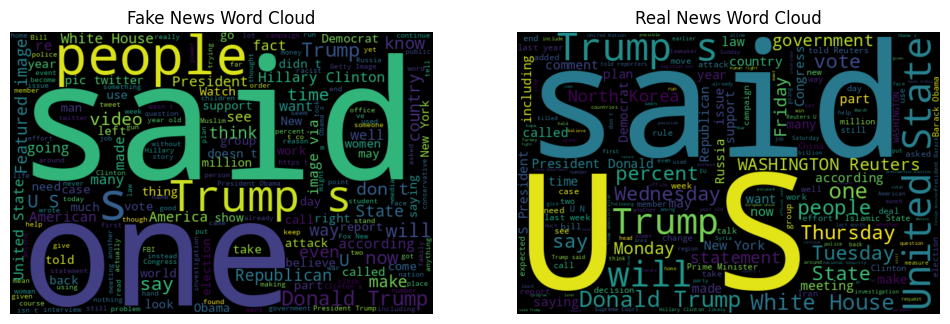

In [13]:
# create a wordcloud for common words visualization

fake_text = ' '.join(news[news['label'] == 0]['title+text'])
real_text = ' '.join(news[news['label'] == 1]['title+text'])

fake_wordcloud = WordCloud(width=600, height=400).generate(fake_text)
real_wordcloud = WordCloud(width=600, height=400).generate(real_text)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('Real News Word Cloud')
plt.axis('off')

plt.show()

# 5 Clean Text

In [14]:
# drop unused columns

news.drop(columns=["text","title","date","subject",'text_length'],inplace=True)

In [15]:
def clean_text(text):
    
    if not isinstance(text, str):
        return ""
    
    else:
        # lowercase text, then remove URLs, usernames, hashtags, punctuation, numbers, single character, and non-ASCII characters
        text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+|[^\w\s]|[^\x00-\x7F]+|\d+|\b\w\b', ' ', text.lower())
        # normalize white space
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text

In [16]:
news['cleaned_text'] = news['title+text'].apply(clean_text)

print('Example of cleaned text:')
for i in range(0, 1):
    print(f"Original text: {news['title+text'].iloc[i]}")
    print("\n")
    print(f"Cleaned text: {news['cleaned_text'].iloc[i]}\n")

Example of cleaned text:
Original text:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president

# 6 Tokenize Text

tokenize the all words in the data and transform them to be sequences

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['cleaned_text'])

word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing

the size of vocab = 103544


Max length: 7908
Mean length: 401.43543142233506
Median length: 360.0
95th percentile: 882.0


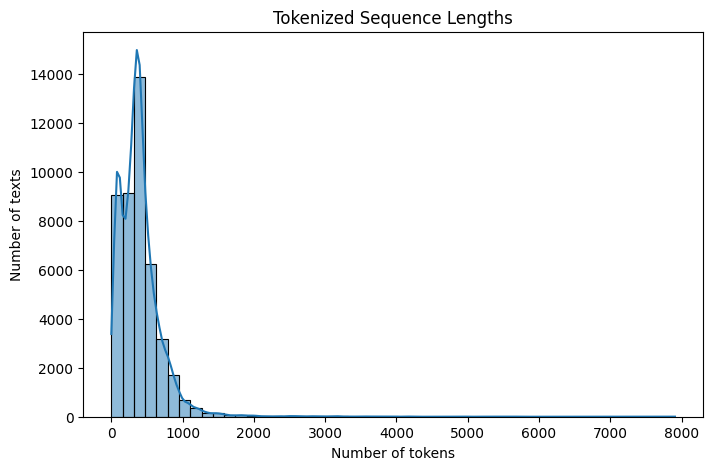

In [18]:
#  look at the distribution of token lengths to decide training maxlens 
news_sequences = tokenizer.texts_to_sequences(news['cleaned_text'])

sequence_lengths = [len(seq) for seq in news_sequences]

print("Max length:", np.max(sequence_lengths))
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("95th percentile:", np.percentile(sequence_lengths, 95))

plt.figure(figsize=(8,5))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title("Tokenized Sequence Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Number of texts")
plt.show()

In [19]:
# choosing 350 as maxlen to cover most words

maxlen = 350
padded_news_sequences = pad_sequences(news_sequences,maxlen=maxlen)

print('Sentences converted to sequences of integers')
for i in range(1, 2):
    print(padded_news_sequences[i])

Sentences converted to sequences of integers
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
  6675  5648    10  3511   920   186  1665   264    64   267   222   591
  5857  2910     9   142     2    22   638   181    11    39   145     1
  9133    84   117     3   107     6     1  3483  4268  2515    15    53
  2348     1   130   264    67    11    39  9826    50    25     1   179
     3   274     4     1   243     5   247     2   737    10    16    12
  1797     1  2515     9    21    53   920     1   264   146     2   789
  2210    18     1    55   225   261   103    10    87   819   695  6093
    15  6675     5  9489  2431    54    11  1350  2134     3   186   424
  1090     7   101    62     7   257     3     6  6093   833    74 15924
  1812

# 7 Split Data into train and validation sets

In [20]:
# Set batch size
BATCH_SIZE = 500

In [21]:
X_train, X_test, y_train, y_test = train_test_split(padded_news_sequences, news['label'], test_size=0.2, random_state=42)

In [22]:
# tf.data.Dataset for efficient data loading
def create_dataset(features, labels, batch_size=500, is_training=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [23]:
# Create the datasets
train_dataset = create_dataset(X_train, y_train, BATCH_SIZE)
val_dataset = create_dataset(X_test, y_test, BATCH_SIZE, is_training=False)

I0000 00:00:1748979457.621707      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748979457.622659      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# 8 Build Model

I wil try both:

    -GRU model 
    -LSTM model
    
The GRU model (Gated Recurrent Unit) is a good choice for this text classification task as it handles sequential data effectively while avoiding the vanaishing gradient problem common in vanilla RNNs. Additionally, compared to other RNNs, the GRU architecture is a good middle ground between performance and computational efficiency.

In [28]:
def build_gru_model(embedding_dim=128, units=64, dropout=0.5):
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=v+1, output_dim=embedding_dim, input_length=maxlen)(inputs)
    x = SpatialDropout1D(dropout)(x)
    x = GRU(units, dropout=dropout, recurrent_dropout=dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=0.001),
        metrics=['accuracy']
        
    )
    
    return model

In [29]:
def build_lstm_model(embedding_dim=128, units=64, dropout=0.5):
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=v+1, output_dim=embedding_dim, input_length=maxlen)(inputs)
    x = Dropout(dropout)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(units, activation='relu')(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss = 'binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# 9 Configure Callbacks

My implementation includes early stopping to prevent overfitting, a model checkpoint to save the best model, and learning rate reduction when performance plateaus

In [26]:
# config callbacks for training
def get_callbacks(model_name = 'gru'):
    if not os.path.exists('/kaggle/working/model_checkpoints'):
        os.makedirs('/kaggle/working/model_checkpoints')

    checkpoint_path = f'/kaggle/working/model_checkpoints/{model_name}_best.keras'

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks

# 10 Train Model

In [30]:
# Create GRU model
gru_model = build_gru_model(
    embedding_dim=128,
    units=64,
    dropout=0.2,
)

# Create LSTM model
lstm_model = build_lstm_model(
    embedding_dim=128,
    units=64,
    dropout=0.5,
)

# Print model summary
print("\nGRU Model Summary:")
gru_model.summary()

print('\n')

print("\nLSTM Model Summary:")
lstm_model.summary()


GRU Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 350)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 350, 128)            │      13,253,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 350, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,291,073 (50.70 MB)

 Trainable params: 13,291,073 (50.70 MB)

 Non-trainable params: 0 (0.00 B)




LSTM Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 350)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 350, 128)            │      13,253,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 350, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 350, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 350, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,393,665 (51.09 MB)

 Trainable params: 13,393,665 (51.09 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train GRU model
print("\nTraining GRU model...")
gru_history = gru_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=get_callbacks('gru'),
    verbose=1
)

# Save training history to CSV
gru_history_df = pd.DataFrame(gru_history.history)
gru_history_df.to_csv('/kaggle/working/model_checkpoints/gru_training_history.csv', index=False)


Training GRU model...
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8143 - loss: 0.4723
Epoch 1: val_loss improved from inf to 0.12846, saving model to /kaggle/working/model_checkpoints/gru_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 947ms/step - accuracy: 0.8153 - loss: 0.4701 - val_accuracy: 0.9514 - val_loss: 0.1285 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.9619 - loss: 0.1082
Epoch 2: val_loss improved from 0.12846 to 0.08601, saving model to /kaggle/working/model_checkpoints/gru_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 942ms/step - accuracy: 0.9620 - loss: 0.1081 - val_accuracy: 0.9697 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9812 - loss: 0.0602
Epoch 3: val_loss did not improve from 0.08601
72/72 ━━━━━━━━━━━━━━━━━━━━ 66s 920ms/step - accuracy: 0.9812 - loss: 0.0602 - val_accuracy: 0.9556 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 4/10
72/72

In [32]:
# Train LSTM model
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=get_callbacks('lstm'),
    verbose=1
)

# Save training history to CSV
lstm_history_df = pd.DataFrame(lstm_history.history)
lstm_history_df.to_csv('/kaggle/working/model_checkpoints/lstm_training_history.csv', index=False)


Training LSTM model...
Epoch 1/10


I0000 00:00:1748980879.081116     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6814 - loss: 0.5823
Epoch 1: val_loss improved from inf to 0.15373, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.6831 - loss: 0.5799 - val_accuracy: 0.9677 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9753 - loss: 0.0781
Epoch 2: val_loss improved from 0.15373 to 0.07300, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9753 - loss: 0.0779 - val_accuracy: 0.9850 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9920 - loss: 0.0290
Epoch 3: val_loss improved from 0.07300 to 0.04179, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.9889 - val_loss: 0.0418 - lear

In [33]:
def plot_accuracy_loss(history, model_name='gru'):
    
    plt.figure(figsize=(10, 5))
    
    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

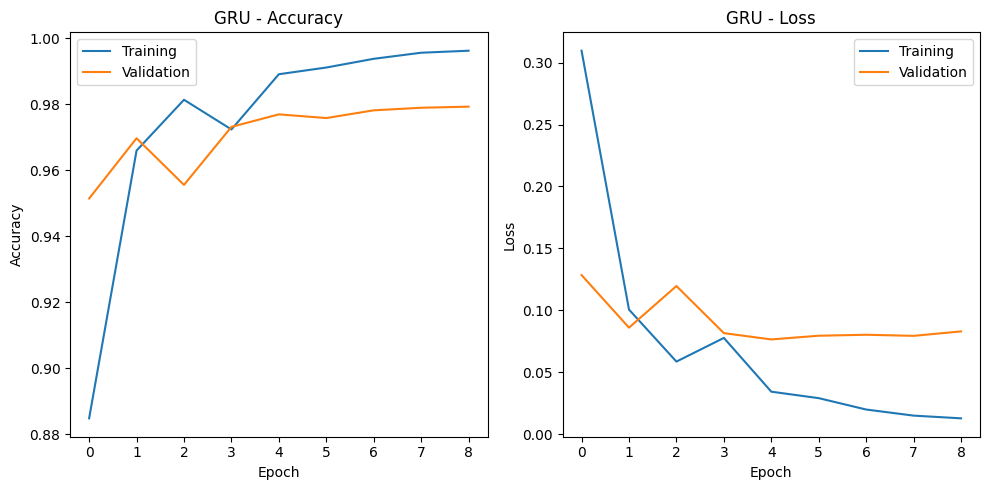

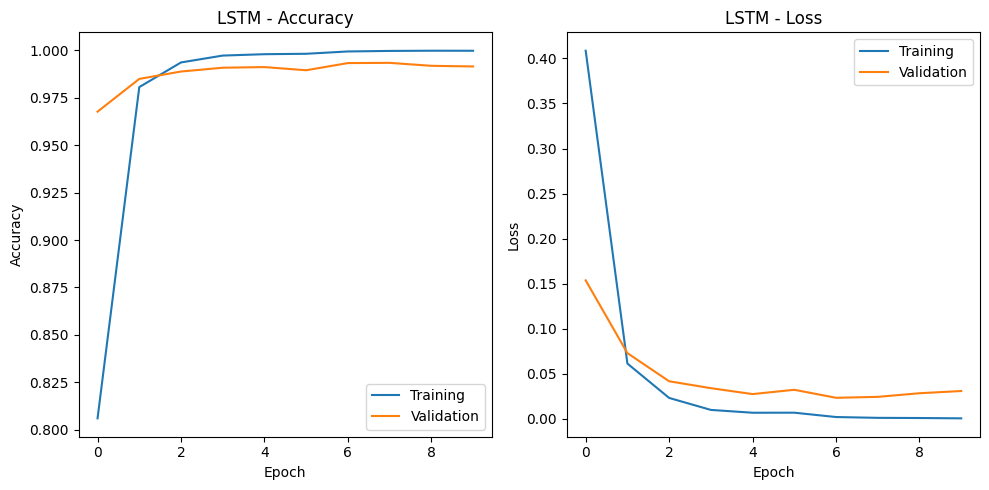

In [34]:
gru_plot = plot_accuracy_loss(gru_history,'GRU')
lstm_plot = plot_accuracy_loss(lstm_history,'LSTM')

# 11 Evaluate Model

In [35]:
# Evaluate model on validation set
gru_y_pred_proba = gru_model.predict(X_test, batch_size=BATCH_SIZE)
gru_y_pred = (gru_y_pred_proba > 0.5).astype(int).flatten()

lstm_y_pred_proba = lstm_model.predict(X_test, batch_size=BATCH_SIZE)
lstm_y_pred = (lstm_y_pred_proba > 0.5).astype(int).flatten()

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [36]:
# Calculate metrics
gru_accuracy = np.mean(gru_y_pred == y_test)
gru_f1 = f1_score(y_test, gru_y_pred)
gru_cm = confusion_matrix(y_test, gru_y_pred)

print("\nGRU Model Evaluation Results:")
print(f"Validation Accuracy: {gru_accuracy:.4f}")
print(f"Validation F1 Score: {gru_f1:.4f}")

lstm_accuracy = np.mean(lstm_y_pred == y_test)
lstm_f1 = f1_score(y_test, lstm_y_pred)
lstm_cm = confusion_matrix(y_test, lstm_y_pred)

print("\nLSTM Model Evaluation Results:")
print(f"Validation Accuracy: {lstm_accuracy:.4f}")
print(f"Validation F1 Score: {lstm_f1:.4f}")


GRU Model Evaluation Results:
Validation Accuracy: 0.9769
Validation F1 Score: 0.9758

LSTM Model Evaluation Results:
Validation Accuracy: 0.9933
Validation F1 Score: 0.9929


In [37]:
# Print classification report
print("\nGRU Model Classification Report:")
print(classification_report(y_test, gru_y_pred, target_names=['Fake News', 'Real News']))

print("\nLSTM Model Classification Report:")
print(classification_report(y_test, gru_y_pred, target_names=['Fake News', 'Real News']))


GRU Model Classification Report:
              precision    recall  f1-score   support

   Fake News       0.98      0.97      0.98      4733
   Real News       0.97      0.98      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980


LSTM Model Classification Report:
              precision    recall  f1-score   support

   Fake News       0.98      0.97      0.98      4733
   Real News       0.97      0.98      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



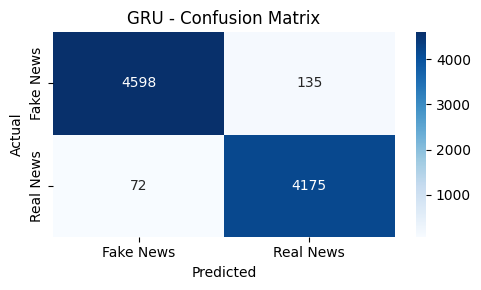

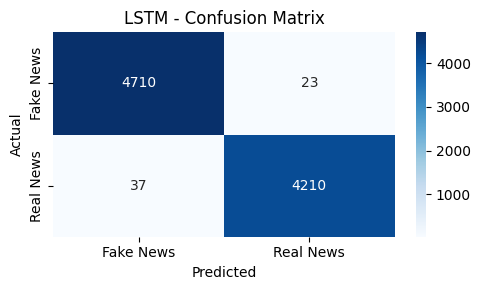

In [38]:
# Plot GRU confusion matrix

plt.figure(figsize=(5, 3))
sns.heatmap(gru_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot LSTM confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.title('LSTM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# 12 Tune Hyperparameters

In [46]:
hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.2},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 200, 'units': 100, 'dropout': 0.4},  # larger embedding, medium units, high dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smaller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]
fine_tuned_models_gru = []
fine_tuned_models_lstm = []

In [47]:
for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    model = build_gru_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )

    # train new model
    model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=get_callbacks('gru'),
        verbose=1
    )
    
    # eval new model
    y_pred_proba = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    
    fine_tuned_models_gru.append({
        'model': model,
        'params': params,
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.2}
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.7872 - loss: 0.4714
Epoch 1: val_loss improved from inf to 0.13328, saving model to /kaggle/working/model_checkpoints/gru_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 913ms/step - accuracy: 0.7884 - loss: 0.4692 - val_accuracy: 0.9499 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9624 - loss: 0.1084
Epoch 2: val_loss improved from 0.13328 to 0.08903, saving model to /kaggle/working/model_checkpoints/gru_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 897ms/step - accuracy: 0.9625 - loss: 0.1083 - val_accuracy: 0.9688 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.9812 - loss: 0.0594
Epoch 3: val_loss improved from 0.08903 to 0.07737, saving model to /kaggle/working/model_checkpoints/gru_best.keras
72/72 ━━━━━━━━━━━━━━━

In [48]:
for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    model = build_lstm_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )

    # train new model
    model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=get_callbacks('lstm'),
        verbose=1
    )
    
    # eval new model
    y_pred_proba = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    
    fine_tuned_models_lstm.append({
        'model': model,
        'params': params,
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.2}
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7163 - loss: 0.5613
Epoch 1: val_loss improved from inf to 0.14419, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.7177 - loss: 0.5592 - val_accuracy: 0.9420 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9663 - loss: 0.1009
Epoch 2: val_loss improved from 0.14419 to 0.05688, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9664 - loss: 0.1006 - val_accuracy: 0.9831 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9903 - loss: 0.0317
Epoch 3: val_loss improved from 0.05688 to 0.03728, saving model to /kaggle/working/model_checkpoints/lstm_best.keras
72/72 ━━━━━━━━━━━━━━━━

In [49]:
# pick the best model
best_model_index = np.argmax([m['f1_score'] for m in fine_tuned_models_gru])
best_model = fine_tuned_models_gru[best_model_index]

print(f"\nBest model (model {best_model_index+1}):")
print(f"Parameters: {best_model['params']}")
print(f"Validation Accuracy: {best_model['accuracy']:.4f}")
print(f"Validation F1 Score: {best_model['f1_score']:.4f}")

best_model_index = np.argmax([m['f1_score'] for m in fine_tuned_models_lstm])
best_model = fine_tuned_models_lstm[best_model_index]

print(f"\nBest model (model {best_model_index+1}):")
print(f"Parameters: {best_model['params']}")
print(f"Validation Accuracy: {best_model['accuracy']:.4f}")
print(f"Validation F1 Score: {best_model['f1_score']:.4f}")


Best model (model 5):
Parameters: {'embedding_dim': 100, 'units': 32, 'dropout': 0.1}
Validation Accuracy: 0.9830
Validation F1 Score: 0.9820

Best model (model 4):
Parameters: {'embedding_dim': 256, 'units': 64, 'dropout': 0.2}
Validation Accuracy: 0.9943
Validation F1 Score: 0.9940


# 13 Conclusion

This project demonstrates the effective application of LSTM and GRU to the task of classifying fake news and real news. The after trying different hyperparameters, both models achieve a very good result on the validation dataset. The implementaiton of callbacks helped prevent overfitting and saved the best model overall. Although the training shows promising result on the current dataset, it might not generalized well for new dataset. For some possible improvement in the future, I could experiment with pre-trained embedding such as GloVe or Word2Vec.  


# Github

Notebook is available on github: 